## Testing access time for ICESat-2 ATL03 HDF5 files in the cloud.

This notebook requires that we have cloud optimized versions of an HDF5 file.


In [1]:
import xarray as xr
import h5py
import fsspec
import s3fs
import logging
import re
import time
import numpy as np
import zarr
import ujson
import pandas as pd
import matplotlib.pyplot as plt

from h5coro import h5coro, s3driver, filedriver
driver =  s3driver.S3Driver

logger = logging.getLogger('fsspec')
logger.setLevel(logging.DEBUG)

In [60]:
for library in (xr, h5py, fsspec, h5coro, zarr):
    print(f'{library.__name__} v{library.__version__}')

xarray v2024.6.0
h5py v3.11.0
fsspec v2024.6.0
h5coro v0.0.6
zarr v2.18.2


For listing available test files

```bash
aws s3 ls s3://its-live-data/test-space/cloud-experiments/h5cloud/ --recursive
```

In [61]:
test_dict = {
    "ATL03-1GB": {
        "links": {
            "original": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5",
            "original-kerchunk": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.json",
            "page-only-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5",
            "page-only-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5",
            "rechunked-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-4mb.h5",
            "rechunked-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.h5",
            "rechunked-8mb-kerchunk": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.json",
            
        },
        "group": "/gt1l/heights", # For simplicity we only read one variable
        "variable": "h_ph"
    }
}

# This will use the embedded credentials in the hub to access the s3://nasa-cryo-persistent bucket
fs = s3fs.S3FileSystem(anon=True)


## [h5coro](https://github.com/ICESat2-SlideRule/h5coro/)

**h5coro** is optimized for reading HDF5 data in high-latency high-throughput environments.  It accomplishes this through a few key design decisions:
* __All reads are concurrent.__  Each dataset and/or attribute read by **h5coro** is performed in its own thread.
* __Intelligent range gets__ are used to read as many dataset chunks as possible in each read operation.  This drastically reduces the number of HTTP requests to S3 and means there is no longer a need to re-chunk the data (it actually works better on smaller chunk sizes due to the granularity of the request).
* __Block caching__ is used to minimize the number of GET requests made to S3.  S3 has a large first-byte latency (we've measured it at ~60ms on our systems), which means there is a large penalty for each read operation performed.  **h5coro** performs all reads to S3 as large block reads and then maintains data in a local cache for access to smaller amounts of data within those blocks.
* __The system is serverless__ and does not depend on any external services to read the data. This means it scales naturally as the user application scales, and it reduces overall system complexity.
* __No metadata repository is needed.__  The structure of the file are cached as they are read so that successive reads to other datasets in the same file will not have to re-read and re-build the directory structure of the file.


In [62]:
h5coro_beanchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        if "kerchunk" in k or link.endswith(".json"):
            print(f"Skipping {link}")
            continue
        print (f"Processing format: {k}, link: {link}")
        group = dataset["group"]
        variable = dataset['variable']     
        final_h5coro_array = []
        start = time.time()
        if link.startswith("s3://nasa-cryo-persistent/"):
            h5obj = h5coro.H5Coro(link.replace("s3://", ""), s3driver.S3Driver)
        else:
            h5obj = h5coro.H5Coro(link.replace("s3://", ""), s3driver.S3Driver, credentials={"annon": True})
        ds = h5obj.readDatasets(datasets=[f'{group}/{variable}'], block=True)
        data = ds[f'{group}/{variable}']
        data_mean = np.mean(data)
        elapsed = time.time() - start
        
        h5coro_beanchmarks.append({"tool": "h5coro",
                                   "dataset": key,
                                   "cloud-aware": "no",
                                   "format": k,
                                   "file": link,
                                   "time": elapsed,
                                   "shape": data.shape,
                                   "mean": data_mean})

Processing format: original, link: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5
Skipping s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.json
Processing format: page-only-4mb, link: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing format: page-only-8mb, link: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing format: rechunked-4mb, link: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-4mb.h5
Processing format: rechunked-8mb, link: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.h5
Skipping s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_0

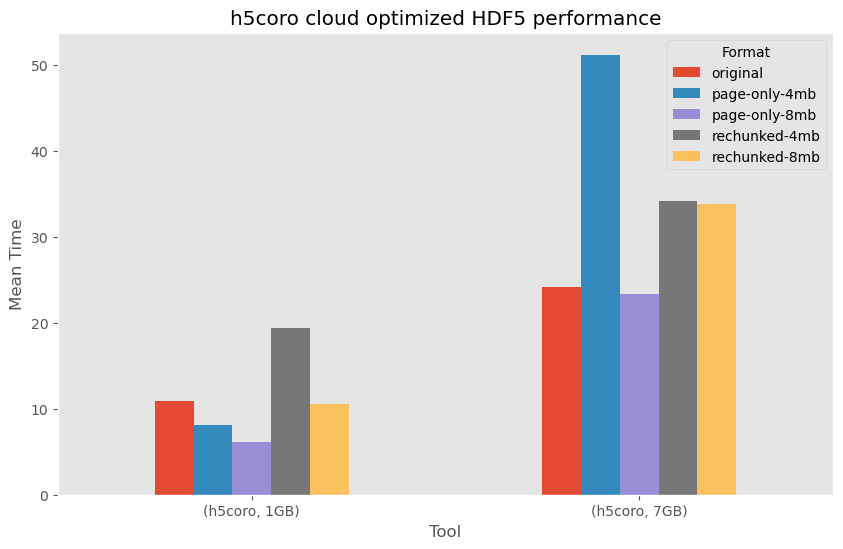

In [63]:
df = pd.DataFrame.from_dict(h5coro_beanchmarks)
pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
plt.style.use('fast')
# plt.xkcd()
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('h5coro cloud optimized HDF5 performance')
plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=0)
plt.legend(title='Format')
plt.grid(False)

plt.show()

## Xarray + kerchunk, out of the box performance.

This is the behavior users will encounter without modifying the I/O paramters, note that we are only using fsspec to also log the data transfers.


In [ ]:
# this is what users will encounter without modifying the I/O paramters

regular_xarray_benchmarks = []
kerchunk_benchmarks = []

fs = s3fs.S3FileSystem(anon=True)


def kerchunk_result(metadata: str, dataset: str, variable: str):
    with fs.open(metadata) as f:
        reference = ujson.load(f)

    ds = xr.open_dataset(
        "reference://",
        engine="zarr",
        backend_kwargs={
            "storage_options": {
                "fo": reference,
                "remote_protocol": "s3",
                "remote_options": {"anon": True}
            },
            "consolidated": False
        },
        group=dataset
    )
    return ds[variable]


for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        # log_filename = f"logs/fsspec-xarray-{key}-{k}-default.log"        
        # # Create a new FileHandler for each iteration
        # file_handler = logging.FileHandler(log_filename)
        # file_handler.setLevel(logging.DEBUG)

        # # Add the handler to the root logger
        # logging.getLogger().addHandler(file_handler)
        print (f"Processing format: {k}, link: {link}")
        start = time.time()
        if "kerchunk" in k or link.endswith(".json"):
            ds = kerchunk_result(link, dataset["group"], dataset["variable"])
            data_mean = ds.mean()
            elapsed = time.time() - start
            kerchunk_benchmarks.append(
                {"tool": "kerchunk",
                 "dataset": key,
                 "cloud-aware": "no",
                 "format": k,
                 "file": link,
                 "time": elapsed,
                 "shape": ds.values.shape,
                 "mean": data_mean})                
        else:
            fo = fs.open(link, mode='rb')
            ds = xr.open_dataset(fo,
                                 group=dataset["group"],
                                 engine="h5netcdf")
            # print(ds)
            data_mean = ds[dataset["variable"]].mean()    
            elapsed = time.time() - start
            regular_xarray_benchmarks.append(
                {"tool": "xarray",
                 "dataset": key,
                 "cloud-aware": "no",
                 "format": k,
                 "file": link,
                 "time": elapsed,
                 "bytes_requested": fo.cache.total_requested_bytes,
                 "shape": ds[dataset["variable"]].values.shape,
                 "mean": data_mean})
            # logging.getLogger().removeHandler(file_handler)
            # file_handler.close()

Processing format: original, link: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5


### Plotting Results

<Figure size 2000x500 with 0 Axes>

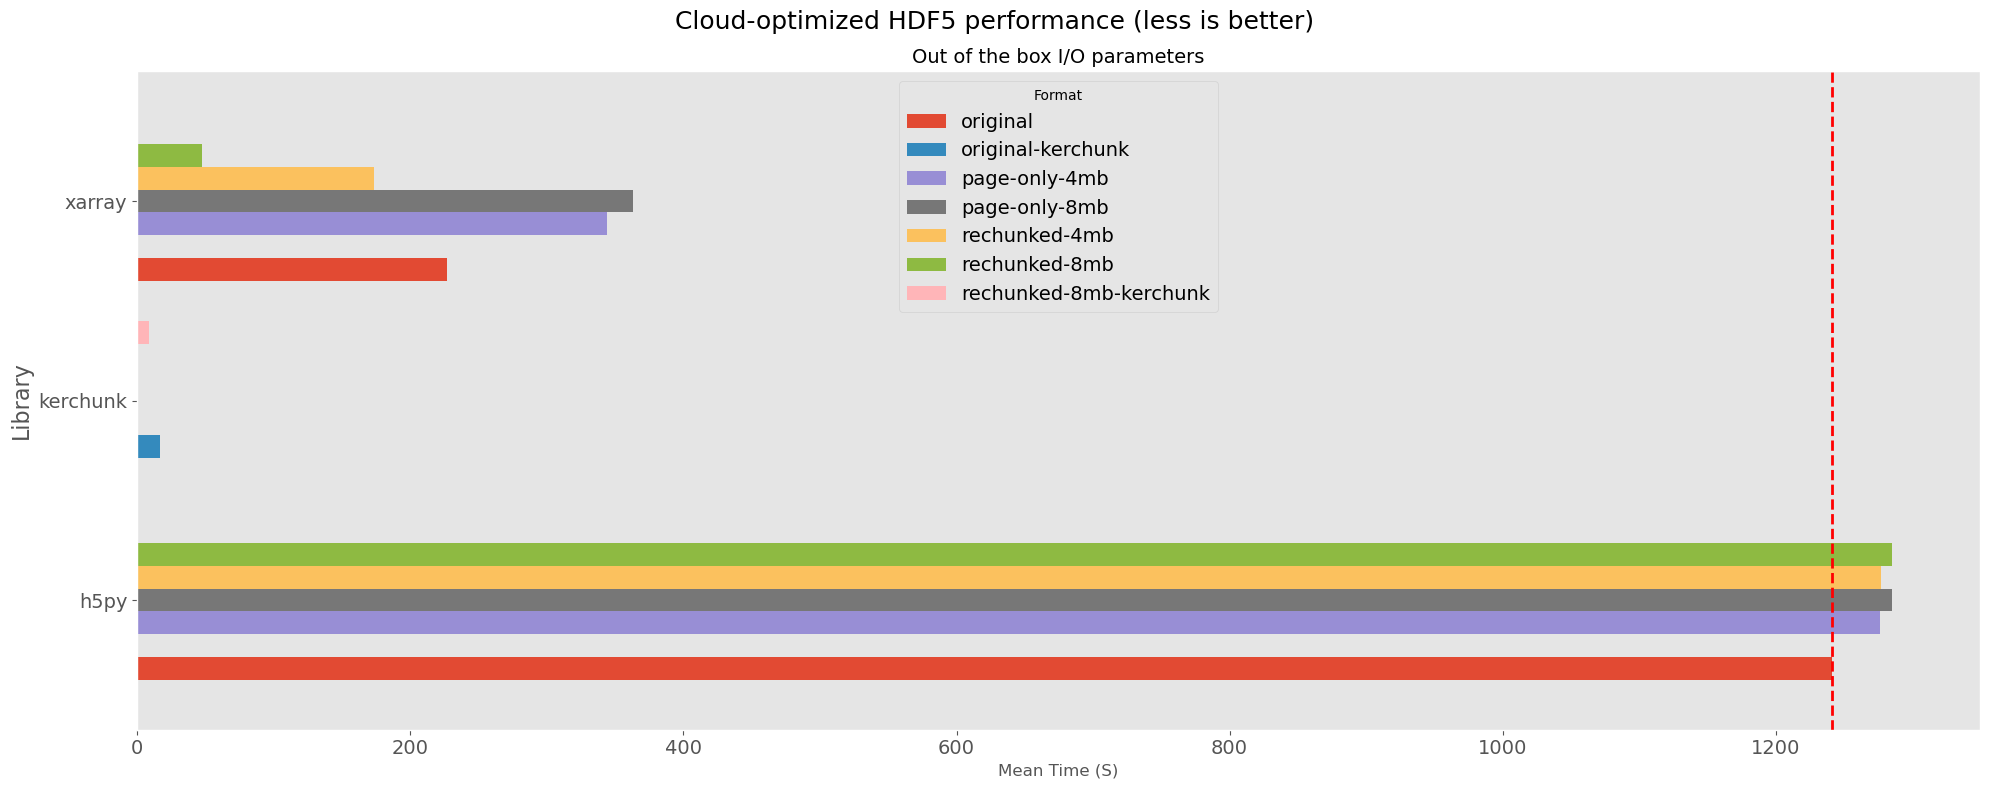

In [59]:
df = pd.DataFrame.from_dict(kerchunk_benchmarks + regular_xarray_benchmarks + regular_h5py_benchmarks)

plt.figure(figsize=(20, 5)) 
plt.style.use('ggplot')
# plt.style.use('grayscale')

pivot_df = df.pivot_table(index=['tool',], columns=['format', ], values='time', aggfunc='mean')
baseline_original = pivot_df['original'].max()
kerchunk_original = pivot_df['original-kerchunk'].max()

# Plotting
pivot_df.plot(kind='barh', figsize=(20, 8), fontsize=14, width=0.8)

plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=18)
plt.title("Out of the box I/O parameters", fontsize=14)
plt.xlabel('Mean Time (S)')
plt.ylabel('Library', fontsize=16)
plt.xticks(rotation=0)
plt.legend(title='Format', fontsize=14)
plt.grid(False)


plt.axvline(x=baseline_original, color='red', linestyle='--', linewidth=2, label=f"Baseline: {baseline_original:.2f}")


plt.tight_layout()
plt.savefig("stats.png", transparent=True, dpi=150)

plt.show()

## h5py out of the box performance.

In [57]:
regular_h5py_benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        try:
            if "kerchunk" in k or link.endswith(".json"):
                continue   
            print (f"Processing: {link}")
            start = time.time()
            fo = fs.open(link, cache_type=None, mode="rb")
            with h5py.File(fo) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                regular_h5py_benchmarks.append(
                    {"tool": "h5py",
                     "dataset": key,
                     "cloud-aware": "no",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "shape": data.shape,
                     "bytes_requested": fo.cache.total_requested_bytes,
                     "mean": data_mean})
        except Exception as e:
            print(e)

Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-8mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-8mb.h5


### Plotting Results

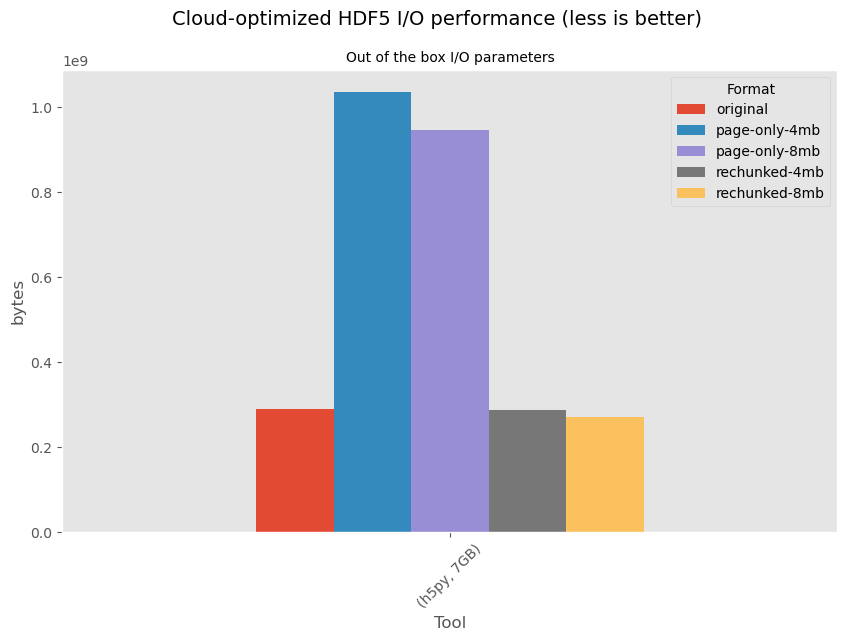

In [56]:
df = pd.DataFrame.from_dict(regular_h5py_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='bytes_requested', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.suptitle('Cloud-optimized HDF5 I/O performance (less is better)', fontsize=14)
plt.title("Out of the box I/O parameters", fontsize=10)

plt.xlabel('Tool')
plt.ylabel('bytes')
plt.xticks(rotation=45)
plt.legend(title='Format')
plt.grid(False)
plt.show()

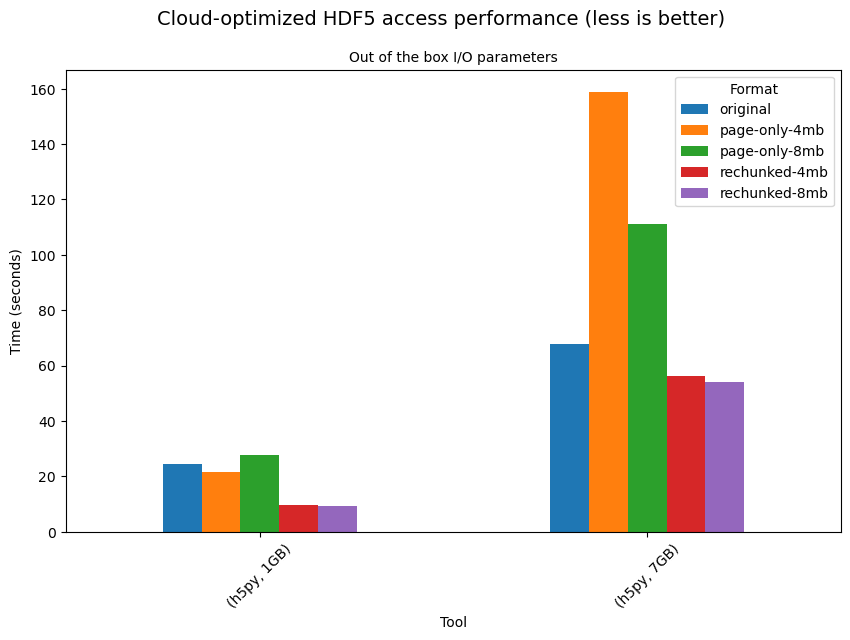

In [20]:
df = pd.DataFrame.from_dict(regular_h5py_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.suptitle('Cloud-optimized HDF5 access performance (less is better)', fontsize=14)
plt.title("Out of the box I/O parameters", fontsize=10)

plt.xlabel('Tool')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Format')
plt.grid(False)
plt.show()

## Aggregated plot by tool and different file sizes

In [51]:
df = pd.DataFrame.from_dict(regular_h5py_benchmarks + kerchunk_benchmarks + regular_xarray_benchmarks + h5coro_beanchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(15, 5))
plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=14)
plt.title("Out of the box I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Mean Time (S)')
plt.xticks(rotation=0)
plt.legend(title='Format')
plt.grid(False)
plt.savefig("stats.png", transparent=None, dpi=150)


In [29]:
df.to_csv("benchmarks.csv")

## Now leet's run the tests with "informed" parameters, this is a I/O that aligns to the cloud-optimized granules chunking strategy and consolidated metadata.


In [52]:
optimized_h5py_benchmarks = []
optimized_xarray_benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        print(f"Processing: {link}")
        try:
            log_filename = f"logs/fsspec-xarray-{key}-{k}.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            
            io_params = {
                "fsspec_params": {},
                "h5py_params": {}
            }
            
            if "rechunked" in link or "page" in link:
                io_params ={
                    "fsspec_params": {
                        "cache_type": "blockcache",
                        "block_size": 8*1024*1024
                    },
                    "h5py_params" : {
                        "driver_kwds": {
                            "page_buf_size": 32*1024*1024,
                            "rdcc_nbytes": 4*1024*1024
                        }

                    }
                }

            if "kerchunk" in k or link.endswith(".json"):
                continue
               
            start = time.time()
            fo = fs.open(link, mode='rb', **io_params["fsspec_params"])
            ds = xr.open_dataset(fo,
                                 group=dataset["group"],
                                 **io_params["h5py_params"],
                                 engine="h5netcdf",
                                 decode_cf=False)
            data_mean = ds[dataset["variable"]].mean()
            elapsed = time.time() - start
            optimized_xarray_benchmarks.append(
                {"tool": "xarray",
                 "dataset": key,
                 "cloud-aware": "yes",
                 "format": k,
                 "file": link,
                 "time": elapsed,
                 "shape": ds[dataset["variable"]].values.shape,
                 "bytes_requested": fo.cache.total_requested_bytes,
                 "mean": data_mean})
            
            logging.getLogger().removeHandler(file_handler)
            file_handler.close()

        except Exception as e:
            print(e)
            
for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        try:
            if "kerchunk" in k or link.endswith(".json"):
                continue   
            print (f"Processing: {link}")
            log_filename = f"logs/fsspec-h5py-{key}-{k}_default.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            # this is mostly IO so no perf_counter is needed
            start = time.time()
            io_params = {
                "fsspec_params": {},
                "h5py_params": {}
            }
            
            if "rechunked" in link or "page" in link:
                io_params ={
                    "fsspec_params": {
                        "cache_type": "blockcache",
                        "block_size": 8*1024*1024
                    },
                    "h5py_params" : {
                        "page_buf_size": 32*1024*1024,
                        "rdcc_nbytes": 4*1024*1024
                    }
                }
            fo = fs.open(link, mode="rb", **io_params["fsspec_params"])
            with h5py.File(fo, **io_params["h5py_params"]) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                optimized_h5py_benchmarks.append(
                    {"tool": "h5py",
                     "dataset": key,
                     "cloud-aware": "yes",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "shape": data.shape,
                     "bytes_requested": fo.cache.total_requested_bytes,
                     "mean": data_mean})

                logging.getLogger().removeHandler(file_handler)      
                file_handler.close()
            

        except Exception as e:
            print(e)

Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.json
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.json
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_081

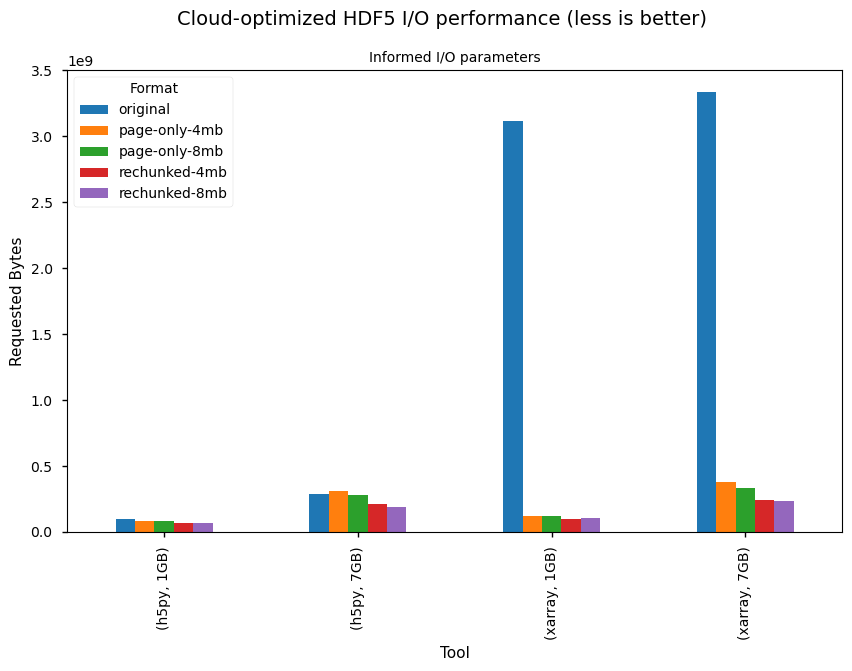

In [54]:
df = pd.DataFrame.from_dict(optimized_h5py_benchmarks + optimized_xarray_benchmarks + kerchunk_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='bytes_requested', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))

plt.suptitle('Cloud-optimized HDF5 I/O performance (less is better)', fontsize=14)
plt.title("Informed I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Requested Bytes')
plt.xticks(rotation=90)
plt.legend(title='Format')
ax = plt.gca()
plt.grid(False)
# ax.yaxis.grid(True)

plt.show()

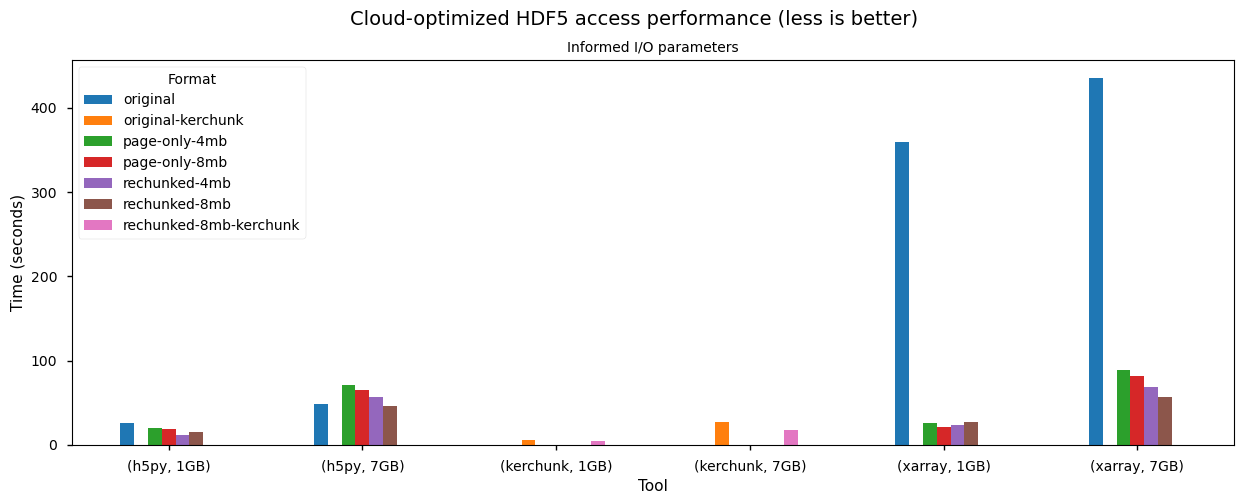

In [60]:
df = pd.DataFrame.from_dict(optimized_h5py_benchmarks + optimized_xarray_benchmarks + kerchunk_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(15, 5))

plt.suptitle('Cloud-optimized HDF5 access performance (less is better)', fontsize=14)
plt.title("Informed I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=0)
plt.legend(title='Format')
ax = plt.gca()
plt.grid(False)
# ax.yaxis.grid(True)

plt.savefig("stats.png", transparent=None, dpi=150)


plt.show()

In [61]:
df.to_csv("benchmarks-optimized.csv")

## Plotting results

<Figure size 2000x500 with 0 Axes>

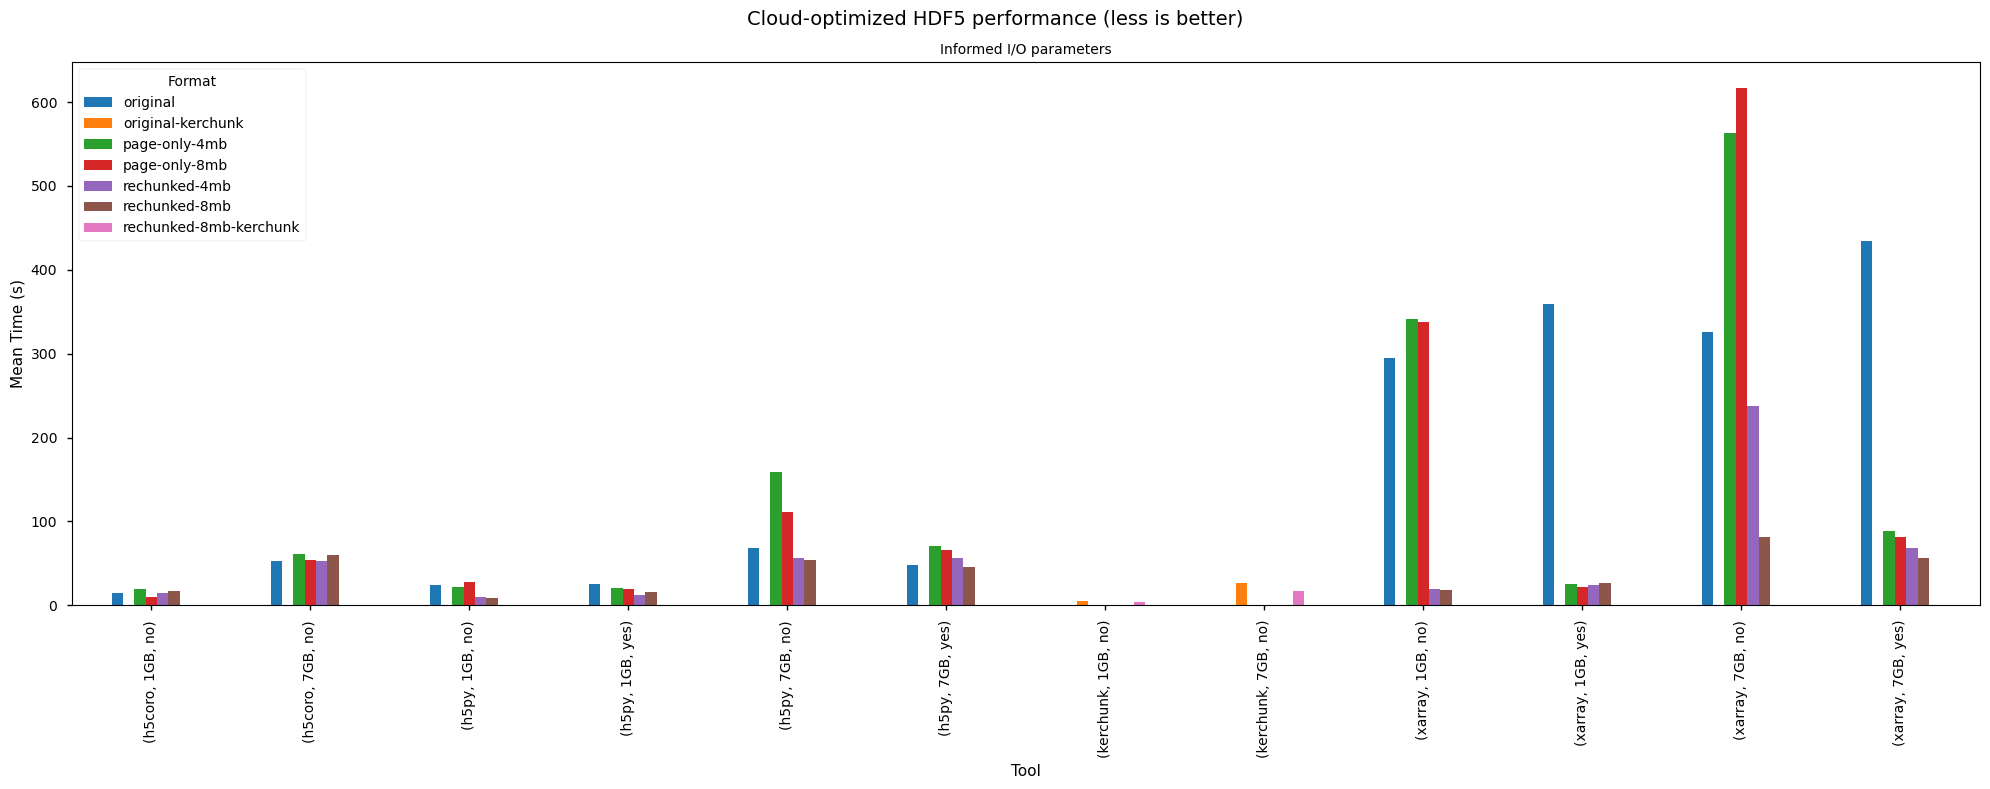

In [80]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

df = pd.DataFrame.from_dict(optimized_h5py_benchmarks+h5coro_beanchmarks+ optimized_xarray_benchmarks+kerchunk_benchmarks +
                            regular_h5py_benchmarks + kerchunk_benchmarks + regular_xarray_benchmarks )

# filtered_df = df[df['dataset'].str.contains("7GB") | df['tool'].str.contains("xarray") ]

plt.figure(figsize=(20, 5)) 


plt.style.use('seaborn-v0_8-notebook')
# plt.style.use('grayscale')

pivot_df = df.pivot_table(index=['tool','dataset','cloud-aware'], columns=['format', ], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(20, 8))

plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=14)
plt.title("Informed I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Mean Time (s)')
plt.xticks(rotation=90)
plt.legend(title='Format')
plt.grid(False)
# ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig("stats.png", transparent=None, dpi=150)

plt.show()

In [72]:
df.to_csv("benchmarks.csv")

## Pliting tool specific performance

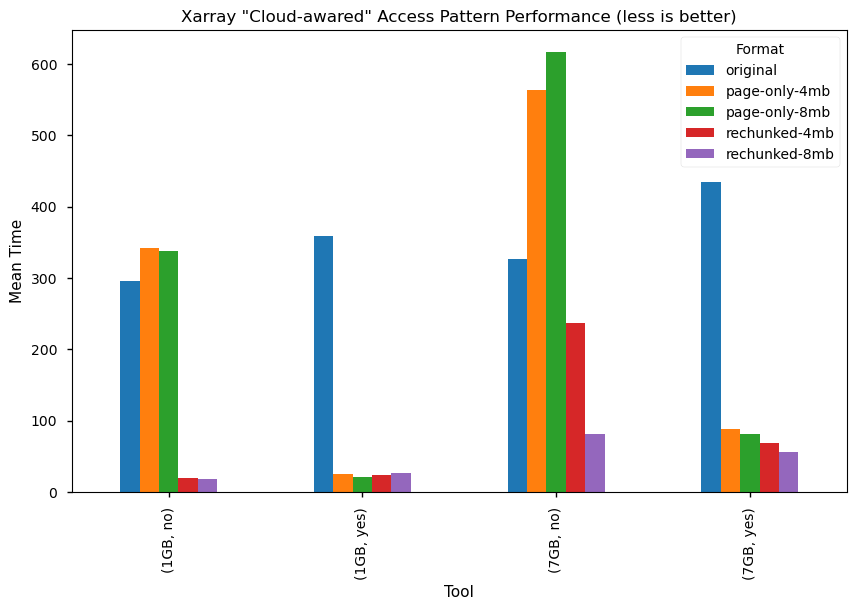

In [74]:
df = pd.DataFrame.from_dict(regular_xarray_benchmarks+optimized_xarray_benchmarks)

pivot_df = df.pivot_table(index=['dataset','cloud-aware'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Xarray "Cloud-awared" Access Pattern Performance (less is better)')
plt.xlabel('Tool')
plt.ylabel('Mean Time')
plt.xticks(rotation=90)
plt.legend(title='Format')

plt.show()